In [19]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get dataset
reviews = pd.read_csv("../data/gojek_reviews.csv")
reviews.head()

,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,Forgot my airport in his car and I didn't rece...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,So far so good,0,2025-02-23 14:04:35,NaN,NaN,5.10.1,5.10.1
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,NaN,NaN,5.11.1,5.11.1
3,451872f2-472a-4696-a6f9-cb5ed515c6b6,arfandi amiruddin,5,Good,0,2025-02-23 12:46:18,NaN,NaN,5.11.1,5.11.1
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,"The ""play later"" Promo is annoying. Can't use ...",1,2025-02-23 12:32:42,NaN,NaN,4.32.1,4.32.1


# 1. Explore the dataset

### a. Analyze the distribution of review lengths

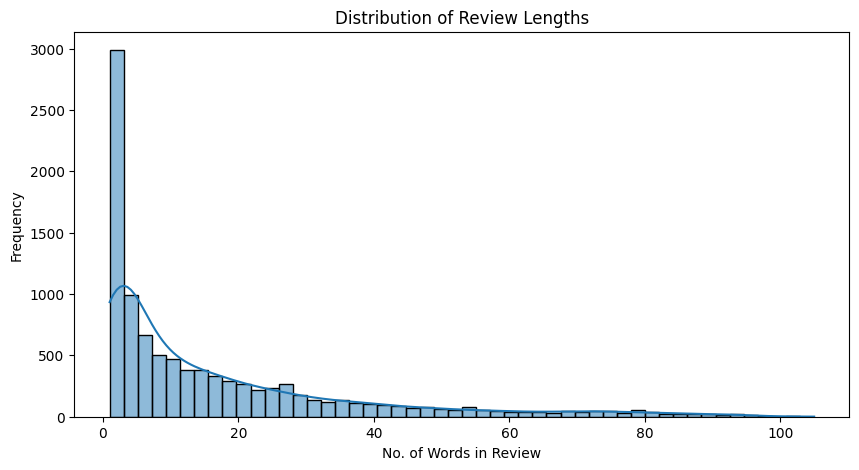

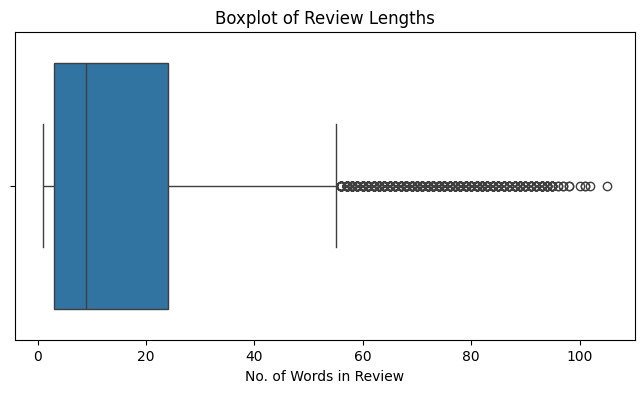

In [20]:
# Add a column for word count
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))

# Histogram to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.xlabel("No. of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=reviews['word_count'])
plt.xlabel("No. of Words in Review")
plt.title("Boxplot of Review Lengths")
plt.show()

The histogram shows a strong right-skewed distribution, meaning most reviews are very short, but the boxplot tells us that there are also many outliers (long reviews).

### b. Identify common words and phrases used in reviews

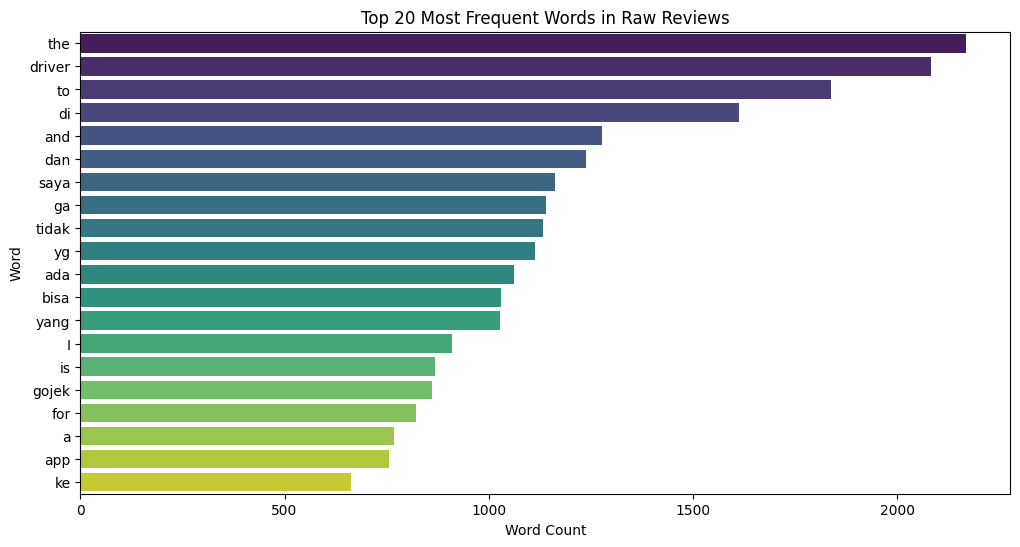

In [21]:
from collections import Counter

# Join all reviews into one string
all_words = ' '.join(reviews['content'].astype(str)).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20
most_common_words = word_freq.most_common(20)

# Seperate the words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Raw Reviews")
plt.show()

### c. Visualize word frequency distributions

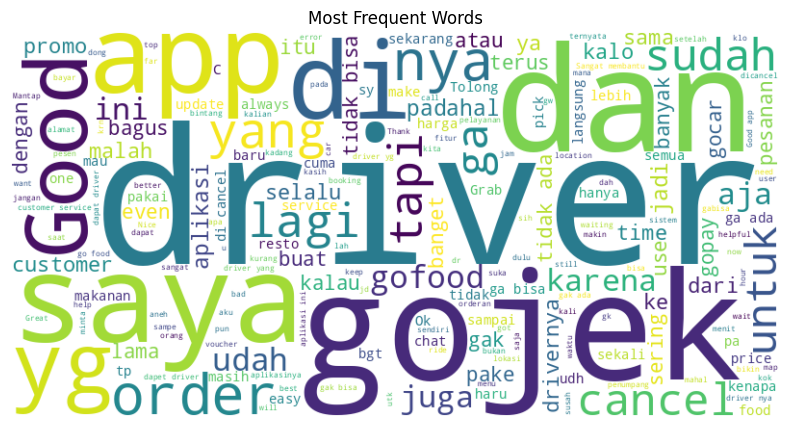

In [22]:
from wordcloud import WordCloud

# Creates word cloud based on word frequency
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words")
plt.show()


# 2. Clean and preprocess text data

### a. Convert text to lowercase

In [23]:
# Convert review content to lowercase
reviews['content'] = reviews['content'].str.lower()

### b. Remove stop words, punctuation, and special characters

In [24]:
# Remove punctuation and special characters
import re
reviews['content'] = reviews['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else x)

# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english')) 

# Load Indonesian stopwords
id_stopwords_path = "../data/id_stopwords.txt"
id_stopwords = set()

with open(id_stopwords_path, 'r') as file:
    for line in file:
        id_stopwords.add(line.strip())

# Combine English & Indonesian stopwords
all_stopwords = english_stopwords.union(id_stopwords)

def remove_stopwords(text):
    if isinstance(text,str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stopwords]
        return ' '.join(filtered_words)
    return text

reviews['content'] = reviews['content'].apply(remove_stopwords)
reviews.dropna(subset=['content'], inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### c. Tokenization and stemming/lemmatization

In [25]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

reviews['lemmatized_content'] = reviews['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### d. Handle duplicate or noisy data

In [26]:
# Handle duplicate and noisy data
print(f"Original dataset shape: {reviews.shape}")

# Check and remove duplicates
duplicate_count = reviews.duplicated(subset=['content']).sum()
print(f"Found {duplicate_count} duplicate reviews")
reviews = reviews.drop_duplicates(subset=['content'])

# Remove very short reviews (likely noise)
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))
short_reviews = reviews[reviews['word_count'] < 2].shape[0]
print(f"Removing {short_reviews} very short reviews (less than 2 words)")
reviews = reviews[reviews['word_count'] >= 2]

# Handle missing values in any other columns
missing_values = reviews.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Fill missing numerical values with median (if any)
numerical_cols = reviews.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].median())

# Fill missing categorical/text values with mode (if any)
categorical_cols = reviews.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'content' and col != 'lemmatized_content' and reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].mode()[0])

# Check for outliers in rating (if present)
if 'rating' in reviews.columns:
    print("\nRating distribution:")
    print(reviews['rating'].value_counts())
    
    # Check if there are invalid ratings outside expected range (e.g., 1-5)
    invalid_ratings = reviews[(reviews['rating'] < 1) | (reviews['rating'] > 5)].shape[0]
    if invalid_ratings > 0:
        print(f"Found {invalid_ratings} reviews with invalid ratings")
        # Remove or fix invalid ratings
        reviews = reviews[(reviews['rating'] >= 1) & (reviews['rating'] <= 5)]

print(f"\nCleaned dataset shape: {reviews.shape}")
reviews.head()

Original dataset shape: (10000, 12)
Found 1816 duplicate reviews
Removing 413 very short reviews (less than 2 words)

Missing values in each column:
reviewId                   0
userName                   2
score                      0
content                    0
thumbsUpCount              0
at                         0
replyContent            3111
repliedAt               3111
reviewCreatedVersion    1184
appVersion              1184
word_count                 0
lemmatized_content         0
dtype: int64

Cleaned dataset shape: (7771, 12)


,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion,word_count,lemmatized_content
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,forgot airport car didnt receive infofollow dr...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1,9,forgot airport car didnt receive infofollow dr...
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,far good,0,2025-02-23 14:04:35,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.10.1,5.10.1,2,far good
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.11.1,5.11.1,3,drivernya cakep hehe
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,play later promo annoying cant use anw u keep ...,1,2025-02-23 12:32:42,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,4.32.1,4.32.1,11,play later promo annoying cant use anw u keep ...
5,ac4fed4e-7bf4-4677-b973-98f4d3c9df0f,Husen Badrutamam,1,jelek banget kelakuan drivernya ambil orderan ...,0,2025-02-23 10:36:21,"Hai Kak Husen, mohon maaf atas ketidaknyamanan...",2025-02-23 11:01:14,5.10.1,5.10.1,16,jelek banget kelakuan drivernya ambil orderan ...


# 3. Topic Modelling

### a. Use algorithms to identify key topics

#### Using Latent Dirichlet Allocation (LDA)

In [27]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Convert each review into a list of words
reviews_tokenized = reviews['lemmatized_content'].astype(str).apply(word_tokenize)

# Assign unique ID to each word
id2word = corpora.Dictionary(reviews_tokenized)

# Convert words to Bag-of-Words format
corpus = [id2word.doc2bow(text) for text in reviews_tokenized]

# No. of topics u want to check
num_topics = 5  

# Train the model
trained_lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=num_topics, 
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)


trained_lda_model.print_topics()


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[(0,
  '0.011*"ok" + 0.009*"mantap" + 0.008*"pin" + 0.008*"meow" + 0.006*"customer" + 0.004*"gojek" + 0.004*"sigma" + 0.004*"easier" + 0.004*"go" + 0.003*"server"'),
 (1,
  '0.034*"driver" + 0.023*"app" + 0.013*"gojek" + 0.012*"time" + 0.011*"good" + 0.011*"order" + 0.011*"service" + 0.008*"get" + 0.007*"use" + 0.007*"even"'),
 (2,
  '0.044*"driver" + 0.017*"gojek" + 0.014*"banget" + 0.011*"drivernya" + 0.010*"aplikasi" + 0.010*"gocar" + 0.010*"cancel" + 0.009*"susah" + 0.009*"dapet" + 0.009*"gofood"'),
 (3,
  '0.033*"driver" + 0.016*"cancel" + 0.013*"aplikasi" + 0.012*"c" + 0.012*"order" + 0.010*"chat" + 0.010*"pesanan" + 0.010*"gofood" + 0.010*"customer" + 0.010*"gojek"'),
 (4,
  '0.024*"gojek" + 0.019*"gopay" + 0.019*"aplikasi" + 0.011*"promo" + 0.010*"bayar" + 0.008*"pakai" + 0.007*"plus" + 0.007*"pake" + 0.007*"mahal" + 0.006*"beli"')]

### Using Non-Negative Matrix Factorization (NMF)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

documents = reviews_tokenized.apply(lambda x: ' '.join(x)).tolist()

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(documents)

tfidf_feature_names = vectorizer.get_feature_names_out()

num_topics = 5  

nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_W = nmf_model.fit_transform(tfidf) 
nmf_H = nmf_model.components_  

for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"{topic_idx+1}:")
    print(" + ".join([tfidf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))


1:
driver + cancel + order + susah + dapet + gocar + nunggu + jam + banget + gofood
2:
good + service + application + far + apps + job + fast + thanks + great + easy
3:
aplikasi + membantu + bagus + banget + sampah + terima + pakai + makanan + update + gopay
4:
app + great + use + easy + best + helpful + nice + time + love + bad
5:
gojek + promo + pake + plus + mahal + gofood + ya + pakai + gopay + drivernya


#### Using BERTopics

In [29]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

bertopic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)
topics, probs = bertopic_model.fit_transform(documents)
bertopic_model.reduce_topics(documents, nr_topics=5)

for topic_num in range(4):  
    topic = bertopic_model.get_topic(topic_num)
    print(f"{topic_num+1}:")
    print(" + ".join([word for word, _ in topic]))


2025-03-15 13:31:27,955 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/243 [00:00<?, ?it/s]

2025-03-15 13:32:37,274 - BERTopic - Embedding - Completed ✓
2025-03-15 13:32:37,275 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-15 13:32:41,943 - BERTopic - Dimensionality - Completed ✓
2025-03-15 13:32:41,944 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-15 13:32:45,320 - BERTopic - Cluster - Completed ✓
2025-03-15 13:32:45,324 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-15 13:32:45,474 - BERTopic - Representation - Completed ✓
2025-03-15 13:32:45,680 - BERTopic - Topic reduction - Reducing number of topics
2025-03-15 13:32:45,814 - BERTopic - Topic reduction - Reduced number of topics from 108 to 5


1:
driver + gojek + app + aplikasi + order + cancel + customer + gofood + time + service
2:
gojek + good + meow + service + bagus + membantu + ok + mantap + bintang + easy
3:
alamat + lokasi + map + location + titik + address + rumah + salah + berubah + gojek
4:
dark + mode + gelap + darkmode + theme + add + gojek + mata + terang + app


### b. Determine the optimal number of topics using coherence scores or topic coherence visualization

/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is mult

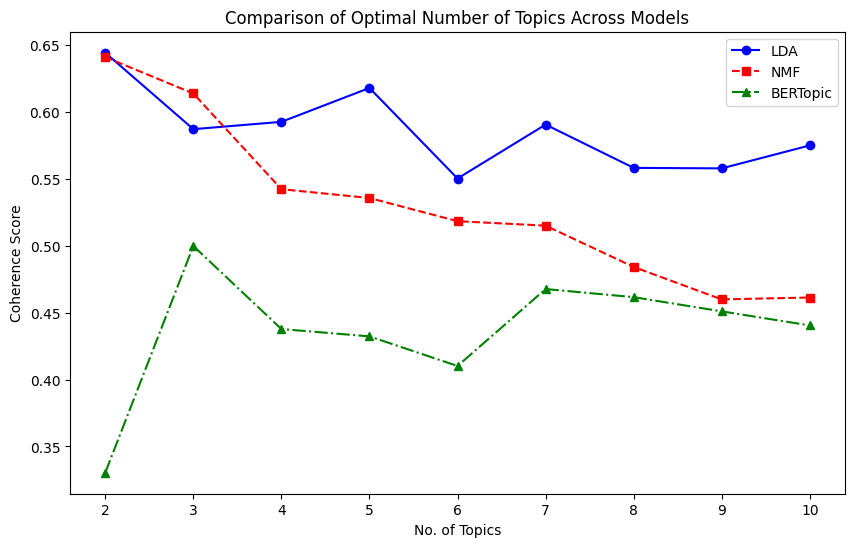

In [30]:
from gensim.models import CoherenceModel, LdaModel
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

texts = reviews_tokenized.tolist()
topic_range = range(2, 11)

# LDA Coherence Scores
coherence_scores_lda = []
for num_topics in topic_range:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha="auto",
        per_word_topics=True,
    )

    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=reviews_tokenized.tolist(), dictionary=id2word, coherence="c_v"
    )
    coherence_scores_lda.append(coherence_model_lda.get_coherence())

# NMF Coherence Scores
coherence_scores_nmf = []
for num_topics in topic_range:
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_W = nmf_model.fit_transform(tfidf)

    nmf_topics = [[tfidf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf_model.components_]

    coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_scores_nmf.append(coherence_model_nmf.get_coherence())

# BERTopic Coherence Scores
bertopic_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=False)
topics, _ = bertopic_model.fit_transform(documents)
coherence_scores_bertopic = []

for num_topics in topic_range:
    bertopic_topics = [bertopic_model.get_topic(i) for i in range(num_topics) if bertopic_model.get_topic(i)]
    bertopic_topics = [[word for word, _ in topic] for topic in bertopic_topics]

    coherence_model_bertopic = CoherenceModel(topics=bertopic_topics, texts=texts, dictionary=id2word, coherence="c_v")
    coherence_scores_bertopic.append(coherence_model_bertopic.get_coherence())

plt.figure(figsize=(10, 6))

plt.plot(topic_range, coherence_scores_lda, marker="o", linestyle="-", label="LDA", color="blue")
plt.plot(topic_range, coherence_scores_nmf, marker="s", linestyle="--", label="NMF", color="red")
plt.plot(topic_range, coherence_scores_bertopic, marker="^", linestyle="-.", label="BERTopic", color="green")

plt.xlabel("No. of Topics")
plt.ylabel("Coherence Score")
plt.title("Comparison of Optimal Number of Topics Across Models")
plt.legend()
plt.show()


Based on the plotting, we should select 5 topics as it provides a balance between coherence and interpretability across LDA, NMF, and BERTopic. Beyond this point, coherence scores showed diminishing returns, indicating that additional topics may introduce redundancy.

### c. Interpret and label discovered topics based on word distribution

#### Using LDA
Topic 1: Gocar Driver Issues
- Keywords: "driver", "cancel", "gocar", "susah", "drivernya", "dapet", "order", "banget", "titik", "gojek"

Topic 2: Customer Experience
- Keywords: "driver", "app", "gojek", "time", "good", "order", "service", "get", "customer", "cancel"

Topic 3: Promo & Account Verification
- Keywords: "gojek", "promo", "mantap", "akun", "meow", "plus", "pin", "bagus", "verifikasi", "email"

Topic 4: GoFood Service
- Keywords: "driver", "gofood", "gojek", "aplikasi", "pesanan", "gopay", "makanan", "cancel"

Topic 5: Experience With Promo
- Keywords: "gojek", "aplikasi", "driver", "promo", "membantu", "pake", "pakai", "plus", "banget", "bagus"


#### Using NMF
Topic 1: Gocar Driver Issues
- Keywords: "driver", "cancel", "order", "susah", "dapet", "gocar", "nunggu", "jam", "banget", "gofood"

Topic 2: User Satisfaction
- Keywords: "good", "service", "application", "far", "apps", "job", "fast", "thanks", "great", "easy"

Topic 3: User Satisfaction
- Keywords: "aplikasi", "membantu", "bagus", "banget", "sampah", "terima", "pakai", "makanan", "update", "gopay"

Topic 4: User Satisfaction
- Keywords: "app", "great", "use", "easy", "best", "helpful", "nice", "time", "bad", "love"

Topic 5: Payment Feedback
- Keywords: gojek", "promo", "pake", "plus", "mahal", "gofood", "ya", "pakai", "gopay", "drivernya"

#### Using BERTopic
Topic 1:  Gofood Service
- Keywords: "driver", "cancel", "gojek", "order", "app", "customer", "gofood", "food", "time", "gocar"

Topic 2: User Satisfaction
- Keywords: "good", "gojek", "bagus", "ok", "service", "membantu", "bintang", "mantap", "easy", "banget"

Topic 3: User Satisfaction
- Keywords:  "app", "aplikasi", "map", "apps", "promo", "gojek", "login", "iklan", "update", "chat"

Topic 4: Dark Mode preference
- Keywords: "dark", "mode", "gelap", "color", "darkmode", "theme", "add", "gojek", "mata", "terang"

Topic 5: 
- Keywords: 


## 4. Evaluate topic modelling results

/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


/home/codespace/.python/current/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2455) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Coherence Score (c_v): 0.6181
Coherence Score (UMass): -5.2458

Model Evaluation:
----------------
Perplexity: -7.7641
Coherence Score (c_v): 0.6181
Coherence Score (UMass): -5.2458


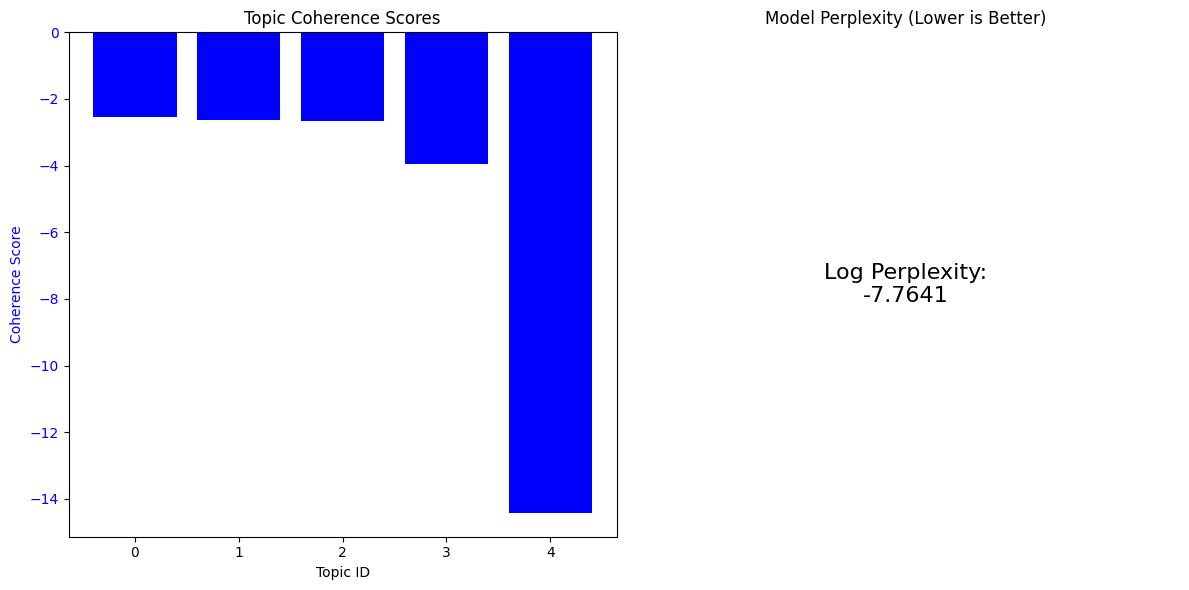


Topic Interpretation:
---------------------
Topic #1: 0.011*"ok" + 0.009*"mantap" + 0.008*"pin" + 0.008*"meow" + 0.006*"customer" + 0.004*"gojek" + 0.004*"sigma" + 0.004*"easier" + 0.004*"go" + 0.003*"server"
Interpretation: General customer interactions and platform features

Topic #2: 0.034*"driver" + 0.023*"app" + 0.013*"gojek" + 0.012*"time" + 0.011*"good" + 0.011*"order" + 0.011*"service" + 0.008*"get" + 0.007*"use" + 0.007*"even"
Interpretation: Driver service and app usage experience

Topic #3: 0.044*"driver" + 0.017*"gojek" + 0.014*"banget" + 0.011*"drivernya" + 0.010*"aplikasi" + 0.010*"gocar" + 0.010*"cancel" + 0.009*"susah" + 0.009*"dapet" + 0.009*"gofood"
Interpretation: Driver cancellations and app issues

Topic #4: 0.033*"driver" + 0.016*"cancel" + 0.013*"aplikasi" + 0.012*"c" + 0.012*"order" + 0.010*"chat" + 0.010*"pesanan" + 0.010*"gofood" + 0.010*"customer" + 0.010*"gojek"
Interpretation: Order process and customer-driver communication

Topic #5: 0.024*"gojek" + 0.019

In [31]:
# Calculate coherence score for the LDA model
from gensim.models import CoherenceModel

# Calculate coherence using c_v measure (most common)
coherence_model_lda = CoherenceModel(
    model=trained_lda_model, 
    texts=reviews_tokenized,
    dictionary=id2word,
    coherence='c_v'
)

coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score (c_v): {coherence_score:.4f}")

# You can also try other coherence measures
coherence_model_umass = CoherenceModel(
    model=trained_lda_model, 
    texts=reviews_tokenized,
    dictionary=id2word,
    coherence='u_mass'  # UMass coherence (usually negative, higher is better)
)

coherence_score_umass = coherence_model_umass.get_coherence()
print(f"Coherence Score (UMass): {coherence_score_umass:.4f}")

print("\nModel Evaluation:")
print("----------------")
perplexity = trained_lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity:.4f}") 
print(f"Coherence Score (c_v): {coherence_score:.4f}")  
print(f"Coherence Score (UMass): {coherence_score_umass:.4f}")  

# Visualize both metrics together
fig, ax1 = plt.figure(figsize=(12, 6)), plt.subplot(121)
ax1.bar(range(len(coherence_scores)), coherence_scores, color='b')
ax1.set_xlabel('Topic ID')
ax1.set_ylabel('Coherence Score', color='b')
ax1.set_title('Topic Coherence Scores')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(len(coherence_scores)))

# Create a separate plot for perplexity
ax2 = plt.subplot(122)
ax2.text(0.5, 0.5, f"Log Perplexity:\n{perplexity:.4f}", 
         horizontalalignment='center', verticalalignment='center', fontsize=16)
ax2.axis('off')
ax2.set_title('Model Perplexity (Lower is Better)')

plt.tight_layout()
plt.show()

print("\nTopic Interpretation:")
print("---------------------")
for topic_id, topic in enumerate(trained_lda_model.print_topics(num_words=10)):
    print(f"Topic #{topic_id + 1}: {topic[1]}")
    
    if topic_id == 0:
        print("Interpretation: General customer interactions and platform features")
    elif topic_id == 1:
        print("Interpretation: Driver service and app usage experience")
    elif topic_id == 2:
        print("Interpretation: Driver cancellations and app issues")
    elif topic_id == 3:
        print("Interpretation: Order process and customer-driver communication")
    elif topic_id == 4:
        print("Interpretation: Payment methods and pricing (focused on GoPay)")
    print()

## 5. Categorize review tags

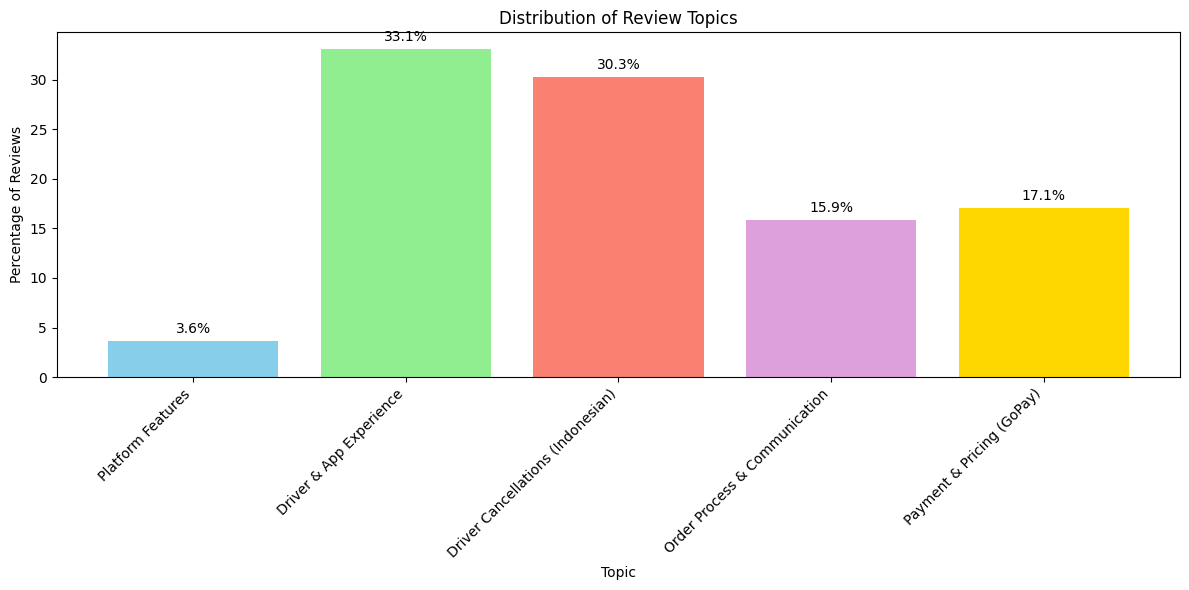

In [34]:
# Visualize distribution of topics
plt.figure(figsize=(12, 6))
bars = plt.bar(
    [topic_names[i] for i in topic_counts.index], 
    topic_proportions,
    color=['skyblue', 'lightgreen', 'salmon', 'plum', 'gold']  # Changed 'lightpurple' to 'plum'
)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.5,
        f"{height:.1f}%",
        ha='center', va='bottom'
    )

plt.title('Distribution of Review Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()